In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from matplotlib import style

# 1 Ingesting data

In [25]:
REBUILD_DATA = True
class CatsVSDogs():
    IMG_SIZE = 50  # 50x50
    CATS = '../data/cats-vs-dogs/PetImages/Cat'
    DOGS = '../data/cats-vs-dogs/PetImages/Dog'
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0  # Need balanced data
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)
        np.save('training_data.npy', self.training_data)
        print('Cats: ', self.catcount)
        print('Dogs: ', self.dogcount)
        

In [26]:
cvd = CatsVSDogs()
cvd.make_training_data()

  1%|          | 74/12501 [00:00<00:16, 739.84it/s]

../data/cats-vs-dogs/PetImages/Cat


  1%|          | 69/12501 [00:00<00:18, 669.75it/s]

../data/cats-vs-dogs/PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 773.21it/s]
C:\Users\abmst\anaconda3\envs\mnist\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats:  12476
Dogs:  12470


# 2 CNN

In [3]:
training_data = np.load('training_Data.npy', allow_pickle=True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5) 
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d((2, 2))
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim=1)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [5]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0  # Scaling pixels to be from (0, 1)
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

In [6]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [7]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [8]:
BATCH_SIZE = 100  # if get memory error, lower batch size
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):  # batches of 100, from 0 to training data with steps of BATCH_SIZE
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        optimizer.zero_grad  # same as doing net.zero_grad() since optimizer linked with model
        outputs = net(batch_X)
        print(outputs[0])
        print(batch_y[0])
        loss = loss_function(outputs, batch_y)
        loss.backward()  # Accumulates loss
        optimizer.step()  # Updates weights

print(loss)

  0%|          | 0/225 [00:00<?, ?it/s]

tensor([0.4856, 0.5144], grad_fn=<SelectBackward>)
tensor([1., 0.])


  1%|          | 2/225 [00:00<00:49,  4.47it/s]

tensor([0.3511, 0.6489], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4364, 0.5636], grad_fn=<SelectBackward>)


  1%|▏         | 3/225 [00:00<00:45,  4.85it/s]

tensor([0., 1.])
tensor([0.5024, 0.4976], grad_fn=<SelectBackward>)


  2%|▏         | 4/225 [00:00<00:44,  4.99it/s]

tensor([0., 1.])
tensor([0.5105, 0.4895], grad_fn=<SelectBackward>)


  2%|▏         | 5/225 [00:01<00:43,  5.06it/s]

tensor([1., 0.])
tensor([0.5028, 0.4972], grad_fn=<SelectBackward>)


  3%|▎         | 6/225 [00:01<00:42,  5.14it/s]

tensor([1., 0.])
tensor([0.4940, 0.5060], grad_fn=<SelectBackward>)


  3%|▎         | 7/225 [00:01<00:42,  5.13it/s]

tensor([0., 1.])
tensor([0.4921, 0.5079], grad_fn=<SelectBackward>)


  4%|▎         | 8/225 [00:01<00:42,  5.13it/s]

tensor([1., 0.])
tensor([0.4961, 0.5039], grad_fn=<SelectBackward>)


  4%|▍         | 9/225 [00:01<00:41,  5.16it/s]

tensor([0., 1.])
tensor([0.5050, 0.4950], grad_fn=<SelectBackward>)


  4%|▍         | 10/225 [00:01<00:41,  5.18it/s]

tensor([1., 0.])
tensor([0.5136, 0.4864], grad_fn=<SelectBackward>)


  5%|▍         | 11/225 [00:02<00:41,  5.20it/s]

tensor([0., 1.])
tensor([0.5362, 0.4638], grad_fn=<SelectBackward>)


  5%|▌         | 12/225 [00:02<00:41,  5.19it/s]

tensor([1., 0.])
tensor([0.5357, 0.4643], grad_fn=<SelectBackward>)


  6%|▌         | 13/225 [00:02<00:40,  5.24it/s]

tensor([0., 1.])
tensor([0.5457, 0.4543], grad_fn=<SelectBackward>)


  6%|▌         | 14/225 [00:02<00:40,  5.25it/s]

tensor([1., 0.])
tensor([0.5339, 0.4661], grad_fn=<SelectBackward>)


  7%|▋         | 15/225 [00:02<00:39,  5.30it/s]

tensor([1., 0.])
tensor([0.5364, 0.4636], grad_fn=<SelectBackward>)


  7%|▋         | 16/225 [00:03<00:39,  5.27it/s]

tensor([1., 0.])
tensor([0.5343, 0.4657], grad_fn=<SelectBackward>)


  8%|▊         | 17/225 [00:03<00:39,  5.21it/s]

tensor([1., 0.])
tensor([0.5144, 0.4856], grad_fn=<SelectBackward>)


  8%|▊         | 18/225 [00:03<00:39,  5.23it/s]

tensor([0., 1.])
tensor([0.5077, 0.4923], grad_fn=<SelectBackward>)


  8%|▊         | 19/225 [00:03<00:39,  5.23it/s]

tensor([0., 1.])
tensor([0.5059, 0.4941], grad_fn=<SelectBackward>)


  9%|▉         | 20/225 [00:03<00:39,  5.21it/s]

tensor([0., 1.])


  9%|▉         | 21/225 [00:04<00:39,  5.19it/s]

tensor([0.4962, 0.5038], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4951, 0.5049], grad_fn=<SelectBackward>)


 10%|▉         | 22/225 [00:04<00:39,  5.20it/s]

tensor([1., 0.])
tensor([0.4940, 0.5060], grad_fn=<SelectBackward>)


 10%|█         | 23/225 [00:04<00:38,  5.21it/s]

tensor([0., 1.])
tensor([0.4917, 0.5083], grad_fn=<SelectBackward>)


 11%|█         | 24/225 [00:04<00:38,  5.20it/s]

tensor([1., 0.])
tensor([0.4886, 0.5114], grad_fn=<SelectBackward>)


 11%|█         | 25/225 [00:04<00:37,  5.27it/s]

tensor([1., 0.])
tensor([0.4897, 0.5103], grad_fn=<SelectBackward>)
tensor([0., 1.])


 12%|█▏        | 27/225 [00:05<00:37,  5.23it/s]

tensor([0.4918, 0.5082], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4951, 0.5049], grad_fn=<SelectBackward>)


 12%|█▏        | 28/225 [00:05<00:37,  5.28it/s]

tensor([0., 1.])
tensor([0.4940, 0.5060], grad_fn=<SelectBackward>)


 13%|█▎        | 29/225 [00:05<00:36,  5.39it/s]

tensor([0., 1.])
tensor([0.4930, 0.5070], grad_fn=<SelectBackward>)
tensor([0., 1.])


 14%|█▍        | 31/225 [00:05<00:36,  5.37it/s]

tensor([0.4961, 0.5039], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4978, 0.5022], grad_fn=<SelectBackward>)


 14%|█▍        | 32/225 [00:06<00:35,  5.39it/s]

tensor([0., 1.])
tensor([0.5152, 0.4848], grad_fn=<SelectBackward>)
tensor([0., 1.])


 15%|█▌        | 34/225 [00:06<00:35,  5.36it/s]

tensor([0.5457, 0.4543], grad_fn=<SelectBackward>)
tensor([1., 0.])


 16%|█▌        | 35/225 [00:06<00:35,  5.31it/s]

tensor([0.4947, 0.5053], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.6252, 0.3748], grad_fn=<SelectBackward>)


 16%|█▌        | 36/225 [00:06<00:34,  5.40it/s]

tensor([1., 0.])
tensor([0.5813, 0.4187], grad_fn=<SelectBackward>)
tensor([1., 0.])


 17%|█▋        | 38/225 [00:07<00:34,  5.44it/s]

tensor([0.4989, 0.5011], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5082, 0.4918], grad_fn=<SelectBackward>)


 17%|█▋        | 39/225 [00:07<00:34,  5.37it/s]

tensor([0., 1.])
tensor([0.6340, 0.3660], grad_fn=<SelectBackward>)


 18%|█▊        | 40/225 [00:07<00:33,  5.45it/s]

tensor([1., 0.])
tensor([0.6089, 0.3911], grad_fn=<SelectBackward>)
tensor([0., 1.])


 19%|█▊        | 42/225 [00:08<00:34,  5.33it/s]

tensor([0.5720, 0.4280], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.6305, 0.3695], grad_fn=<SelectBackward>)


 19%|█▉        | 43/225 [00:08<00:33,  5.41it/s]

tensor([0., 1.])
tensor([0.6006, 0.3994], grad_fn=<SelectBackward>)
tensor([1., 0.])


 20%|██        | 45/225 [00:08<00:33,  5.35it/s]

tensor([0.4893, 0.5107], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.5042, 0.4958], grad_fn=<SelectBackward>)


 20%|██        | 46/225 [00:08<00:32,  5.43it/s]

tensor([0., 1.])
tensor([0.5016, 0.4984], grad_fn=<SelectBackward>)


 21%|██        | 47/225 [00:08<00:33,  5.37it/s]

tensor([0., 1.])
tensor([0.4721, 0.5279], grad_fn=<SelectBackward>)


 21%|██▏       | 48/225 [00:09<00:33,  5.31it/s]

tensor([1., 0.])
tensor([0.4104, 0.5896], grad_fn=<SelectBackward>)


 22%|██▏       | 49/225 [00:09<00:33,  5.25it/s]

tensor([0., 1.])
tensor([0.4138, 0.5862], grad_fn=<SelectBackward>)


 22%|██▏       | 50/225 [00:09<00:33,  5.25it/s]

tensor([1., 0.])
tensor([0.4092, 0.5908], grad_fn=<SelectBackward>)


 23%|██▎       | 51/225 [00:09<00:33,  5.23it/s]

tensor([1., 0.])


 23%|██▎       | 52/225 [00:09<00:32,  5.30it/s]

tensor([0.4144, 0.5856], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.3611, 0.6389], grad_fn=<SelectBackward>)
tensor([1., 0.])


 24%|██▍       | 54/225 [00:10<00:32,  5.23it/s]

tensor([0.3971, 0.6029], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4173, 0.5827], grad_fn=<SelectBackward>)
tensor([0., 1.])


 25%|██▍       | 56/225 [00:10<00:31,  5.32it/s]

tensor([0.4126, 0.5874], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4370, 0.5630], grad_fn=<SelectBackward>)


 25%|██▌       | 57/225 [00:10<00:31,  5.29it/s]

tensor([1., 0.])
tensor([0.4480, 0.5520], grad_fn=<SelectBackward>)


 26%|██▌       | 58/225 [00:11<00:31,  5.30it/s]

tensor([0., 1.])
tensor([0.4529, 0.5471], grad_fn=<SelectBackward>)


 26%|██▌       | 59/225 [00:11<00:31,  5.31it/s]

tensor([0., 1.])
tensor([0.4613, 0.5387], grad_fn=<SelectBackward>)


 27%|██▋       | 60/225 [00:11<00:30,  5.35it/s]

tensor([0., 1.])
tensor([0.4646, 0.5354], grad_fn=<SelectBackward>)
tensor([0., 1.])


 28%|██▊       | 62/225 [00:11<00:30,  5.40it/s]

tensor([0.4673, 0.5327], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4696, 0.5304], grad_fn=<SelectBackward>)
tensor([1., 0.])


 28%|██▊       | 64/225 [00:12<00:30,  5.33it/s]

tensor([0.4718, 0.5282], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4740, 0.5260], grad_fn=<SelectBackward>)
tensor([0., 1.])


 29%|██▉       | 66/225 [00:12<00:30,  5.29it/s]

tensor([0.4761, 0.5239], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4783, 0.5217], grad_fn=<SelectBackward>)


 30%|██▉       | 67/225 [00:12<00:29,  5.27it/s]

tensor([0., 1.])
tensor([0.4805, 0.5195], grad_fn=<SelectBackward>)


 30%|███       | 68/225 [00:12<00:29,  5.25it/s]

tensor([0., 1.])
tensor([0.4827, 0.5173], grad_fn=<SelectBackward>)


 31%|███       | 69/225 [00:13<00:29,  5.23it/s]

tensor([0., 1.])
tensor([0.4849, 0.5151], grad_fn=<SelectBackward>)


 31%|███       | 70/225 [00:13<00:29,  5.25it/s]

tensor([0., 1.])
tensor([0.4871, 0.5129], grad_fn=<SelectBackward>)


 32%|███▏      | 71/225 [00:13<00:29,  5.24it/s]

tensor([1., 0.])
tensor([0.4892, 0.5108], grad_fn=<SelectBackward>)


 32%|███▏      | 72/225 [00:13<00:28,  5.42it/s]

tensor([1., 0.])
tensor([0.4911, 0.5089], grad_fn=<SelectBackward>)
tensor([1., 0.])


 33%|███▎      | 74/225 [00:14<00:27,  5.49it/s]

tensor([0.4929, 0.5071], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4946, 0.5054], grad_fn=<SelectBackward>)
tensor([1., 0.])


 34%|███▍      | 76/225 [00:14<00:27,  5.44it/s]

tensor([0.4963, 0.5037], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4979, 0.5021], grad_fn=<SelectBackward>)


 34%|███▍      | 77/225 [00:14<00:27,  5.37it/s]

tensor([1., 0.])
tensor([0.4994, 0.5006], grad_fn=<SelectBackward>)


 35%|███▍      | 78/225 [00:14<00:27,  5.32it/s]

tensor([1., 0.])
tensor([0.5008, 0.4992], grad_fn=<SelectBackward>)


 35%|███▌      | 79/225 [00:14<00:27,  5.37it/s]

tensor([0., 1.])
tensor([0.5022, 0.4978], grad_fn=<SelectBackward>)
tensor([0., 1.])


 36%|███▌      | 81/225 [00:15<00:26,  5.39it/s]

tensor([0.5035, 0.4965], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5045, 0.4955], grad_fn=<SelectBackward>)


 36%|███▋      | 82/225 [00:15<00:26,  5.31it/s]

tensor([1., 0.])
tensor([0.5056, 0.4944], grad_fn=<SelectBackward>)


 37%|███▋      | 83/225 [00:15<00:26,  5.34it/s]

tensor([0., 1.])
tensor([0.5066, 0.4934], grad_fn=<SelectBackward>)


 37%|███▋      | 84/225 [00:15<00:26,  5.41it/s]

tensor([1., 0.])
tensor([0.5075, 0.4925], grad_fn=<SelectBackward>)


 38%|███▊      | 85/225 [00:16<00:25,  5.40it/s]

tensor([0., 1.])
tensor([0.5084, 0.4916], grad_fn=<SelectBackward>)


 38%|███▊      | 86/225 [00:16<00:26,  5.27it/s]

tensor([0., 1.])
tensor([0.5093, 0.4907], grad_fn=<SelectBackward>)


 39%|███▊      | 87/225 [00:16<00:25,  5.32it/s]

tensor([1., 0.])
tensor([0.5096, 0.4904], grad_fn=<SelectBackward>)


 39%|███▉      | 88/225 [00:16<00:25,  5.29it/s]

tensor([0., 1.])
tensor([0.5109, 0.4891], grad_fn=<SelectBackward>)


 40%|███▉      | 89/225 [00:16<00:25,  5.27it/s]

tensor([1., 0.])
tensor([0.5117, 0.4883], grad_fn=<SelectBackward>)


 40%|████      | 90/225 [00:17<00:25,  5.27it/s]

tensor([0., 1.])
tensor([0.5124, 0.4876], grad_fn=<SelectBackward>)


 40%|████      | 91/225 [00:17<00:24,  5.39it/s]

tensor([0., 1.])
tensor([0.5130, 0.4870], grad_fn=<SelectBackward>)
tensor([0., 1.])


 41%|████▏     | 93/225 [00:17<00:24,  5.31it/s]

tensor([0.5138, 0.4862], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.5145, 0.4855], grad_fn=<SelectBackward>)


 42%|████▏     | 94/225 [00:17<00:24,  5.35it/s]

tensor([0., 1.])
tensor([0.5153, 0.4847], grad_fn=<SelectBackward>)


 42%|████▏     | 95/225 [00:17<00:24,  5.34it/s]

tensor([0., 1.])
tensor([0.5160, 0.4840], grad_fn=<SelectBackward>)


 43%|████▎     | 96/225 [00:18<00:24,  5.27it/s]

tensor([1., 0.])
tensor([0.5165, 0.4835], grad_fn=<SelectBackward>)


 43%|████▎     | 97/225 [00:18<00:24,  5.23it/s]

tensor([1., 0.])
tensor([0.5174, 0.4826], grad_fn=<SelectBackward>)


 44%|████▎     | 98/225 [00:18<00:24,  5.16it/s]

tensor([1., 0.])
tensor([0.5181, 0.4819], grad_fn=<SelectBackward>)


 44%|████▍     | 99/225 [00:18<00:24,  5.25it/s]

tensor([0., 1.])
tensor([0.5192, 0.4808], grad_fn=<SelectBackward>)


 44%|████▍     | 100/225 [00:18<00:24,  5.20it/s]

tensor([0., 1.])
tensor([0.5195, 0.4805], grad_fn=<SelectBackward>)


 45%|████▍     | 101/225 [00:19<00:23,  5.17it/s]

tensor([0., 1.])
tensor([0.5207, 0.4793], grad_fn=<SelectBackward>)


 45%|████▌     | 102/225 [00:19<00:23,  5.24it/s]

tensor([1., 0.])
tensor([0.5256, 0.4744], grad_fn=<SelectBackward>)


 46%|████▌     | 103/225 [00:19<00:22,  5.43it/s]

tensor([0., 1.])
tensor([0.5215, 0.4785], grad_fn=<SelectBackward>)
tensor([1., 0.])


 47%|████▋     | 105/225 [00:19<00:22,  5.42it/s]

tensor([0.5226, 0.4774], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5227, 0.4773], grad_fn=<SelectBackward>)
tensor([0., 1.])


 48%|████▊     | 107/225 [00:20<00:21,  5.53it/s]

tensor([0.5232, 0.4768], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.5236, 0.4764], grad_fn=<SelectBackward>)
tensor([0., 1.])


 48%|████▊     | 109/225 [00:20<00:21,  5.41it/s]

tensor([0.5240, 0.4760], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5247, 0.4753], grad_fn=<SelectBackward>)


 49%|████▉     | 110/225 [00:20<00:21,  5.43it/s]

tensor([0., 1.])
tensor([0.5248, 0.4752], grad_fn=<SelectBackward>)
tensor([0., 1.])


 50%|████▉     | 112/225 [00:21<00:21,  5.31it/s]

tensor([0.5251, 0.4749], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5255, 0.4745], grad_fn=<SelectBackward>)


 50%|█████     | 113/225 [00:21<00:21,  5.28it/s]

tensor([1., 0.])
tensor([0.5260, 0.4740], grad_fn=<SelectBackward>)


 51%|█████     | 114/225 [00:21<00:20,  5.32it/s]

tensor([1., 0.])
tensor([0.5260, 0.4740], grad_fn=<SelectBackward>)


 51%|█████     | 115/225 [00:21<00:20,  5.39it/s]

tensor([0., 1.])
tensor([0.5263, 0.4737], grad_fn=<SelectBackward>)
tensor([1., 0.])


 52%|█████▏    | 117/225 [00:22<00:20,  5.25it/s]

tensor([0.5264, 0.4736], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5268, 0.4732], grad_fn=<SelectBackward>)


 52%|█████▏    | 118/225 [00:22<00:20,  5.25it/s]

tensor([1., 0.])
tensor([0.5267, 0.4733], grad_fn=<SelectBackward>)


 53%|█████▎    | 119/225 [00:22<00:20,  5.25it/s]

tensor([0., 1.])
tensor([0.5268, 0.4732], grad_fn=<SelectBackward>)


 53%|█████▎    | 120/225 [00:22<00:20,  5.19it/s]

tensor([0., 1.])
tensor([0.5268, 0.4732], grad_fn=<SelectBackward>)


 54%|█████▍    | 121/225 [00:22<00:19,  5.21it/s]

tensor([0., 1.])
tensor([0.5268, 0.4732], grad_fn=<SelectBackward>)


 54%|█████▍    | 122/225 [00:23<00:19,  5.32it/s]

tensor([1., 0.])
tensor([0.5269, 0.4731], grad_fn=<SelectBackward>)
tensor([1., 0.])


 55%|█████▌    | 124/225 [00:23<00:18,  5.33it/s]

tensor([0.5268, 0.4732], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.5268, 0.4732], grad_fn=<SelectBackward>)


 56%|█████▌    | 125/225 [00:23<00:18,  5.29it/s]

tensor([1., 0.])
tensor([0.5267, 0.4733], grad_fn=<SelectBackward>)


 56%|█████▌    | 126/225 [00:23<00:18,  5.25it/s]

tensor([1., 0.])
tensor([0.5266, 0.4734], grad_fn=<SelectBackward>)


 56%|█████▋    | 127/225 [00:23<00:18,  5.28it/s]

tensor([0., 1.])
tensor([0.5265, 0.4735], grad_fn=<SelectBackward>)


 57%|█████▋    | 128/225 [00:24<00:18,  5.32it/s]

tensor([0., 1.])
tensor([0.5263, 0.4737], grad_fn=<SelectBackward>)


 57%|█████▋    | 129/225 [00:24<00:18,  5.30it/s]

tensor([0., 1.])
tensor([0.5261, 0.4739], grad_fn=<SelectBackward>)


 58%|█████▊    | 130/225 [00:24<00:18,  5.24it/s]

tensor([0., 1.])
tensor([0.5259, 0.4741], grad_fn=<SelectBackward>)


 58%|█████▊    | 131/225 [00:24<00:17,  5.29it/s]

tensor([0., 1.])
tensor([0.5256, 0.4744], grad_fn=<SelectBackward>)


 59%|█████▊    | 132/225 [00:24<00:17,  5.28it/s]

tensor([1., 0.])
tensor([0.5253, 0.4747], grad_fn=<SelectBackward>)


 59%|█████▉    | 133/225 [00:25<00:17,  5.22it/s]

tensor([1., 0.])
tensor([0.5250, 0.4750], grad_fn=<SelectBackward>)


 60%|█████▉    | 134/225 [00:25<00:17,  5.23it/s]

tensor([0., 1.])
tensor([0.5246, 0.4754], grad_fn=<SelectBackward>)


 60%|██████    | 135/225 [00:25<00:17,  5.22it/s]

tensor([0., 1.])


 60%|██████    | 136/225 [00:25<00:17,  5.19it/s]

tensor([0.5243, 0.4757], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.5238, 0.4762], grad_fn=<SelectBackward>)


 61%|██████    | 137/225 [00:25<00:16,  5.27it/s]

tensor([0., 1.])
tensor([0.5234, 0.4766], grad_fn=<SelectBackward>)


 61%|██████▏   | 138/225 [00:26<00:16,  5.23it/s]

tensor([1., 0.])
tensor([0.5229, 0.4771], grad_fn=<SelectBackward>)


 62%|██████▏   | 139/225 [00:26<00:16,  5.23it/s]

tensor([0., 1.])
tensor([0.5223, 0.4777], grad_fn=<SelectBackward>)


 62%|██████▏   | 140/225 [00:26<00:16,  5.26it/s]

tensor([1., 0.])
tensor([0.5218, 0.4782], grad_fn=<SelectBackward>)


 63%|██████▎   | 141/225 [00:26<00:15,  5.32it/s]

tensor([0., 1.])
tensor([0.5212, 0.4788], grad_fn=<SelectBackward>)


 63%|██████▎   | 142/225 [00:26<00:15,  5.32it/s]

tensor([1., 0.])
tensor([0.5205, 0.4795], grad_fn=<SelectBackward>)


 64%|██████▎   | 143/225 [00:27<00:15,  5.32it/s]

tensor([0., 1.])
tensor([0.5198, 0.4802], grad_fn=<SelectBackward>)


 64%|██████▍   | 144/225 [00:27<00:15,  5.31it/s]

tensor([0., 1.])
tensor([0.5191, 0.4809], grad_fn=<SelectBackward>)


 64%|██████▍   | 145/225 [00:27<00:15,  5.28it/s]

tensor([1., 0.])
tensor([0.5184, 0.4816], grad_fn=<SelectBackward>)


 65%|██████▍   | 146/225 [00:27<00:15,  5.23it/s]

tensor([0., 1.])
tensor([0.5176, 0.4824], grad_fn=<SelectBackward>)


 65%|██████▌   | 147/225 [00:27<00:14,  5.35it/s]

tensor([0., 1.])
tensor([0.5168, 0.4832], grad_fn=<SelectBackward>)
tensor([1., 0.])


 66%|██████▌   | 149/225 [00:28<00:14,  5.28it/s]

tensor([0.5160, 0.4840], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5151, 0.4849], grad_fn=<SelectBackward>)


 67%|██████▋   | 150/225 [00:28<00:14,  5.31it/s]

tensor([1., 0.])
tensor([0.5143, 0.4857], grad_fn=<SelectBackward>)


 67%|██████▋   | 151/225 [00:28<00:13,  5.36it/s]

tensor([1., 0.])
tensor([0.5134, 0.4866], grad_fn=<SelectBackward>)
tensor([1., 0.])


 68%|██████▊   | 153/225 [00:28<00:13,  5.32it/s]

tensor([0.5126, 0.4874], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.5117, 0.4883], grad_fn=<SelectBackward>)


 68%|██████▊   | 154/225 [00:29<00:13,  5.40it/s]

tensor([0., 1.])
tensor([0.5109, 0.4891], grad_fn=<SelectBackward>)
tensor([0., 1.])


 69%|██████▉   | 156/225 [00:29<00:13,  5.24it/s]

tensor([0.5100, 0.4900], grad_fn=<SelectBackward>)
tensor([1., 0.])


 70%|██████▉   | 157/225 [00:29<00:12,  5.26it/s]

tensor([0.5092, 0.4908], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5083, 0.4917], grad_fn=<SelectBackward>)


 70%|███████   | 158/225 [00:29<00:12,  5.21it/s]

tensor([0., 1.])
tensor([0.5074, 0.4926], grad_fn=<SelectBackward>)


 71%|███████   | 159/225 [00:30<00:12,  5.23it/s]

tensor([0., 1.])
tensor([0.5066, 0.4934], grad_fn=<SelectBackward>)
tensor([0., 1.])


 72%|███████▏  | 161/225 [00:30<00:11,  5.43it/s]

tensor([0.5058, 0.4942], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.5050, 0.4950], grad_fn=<SelectBackward>)


 72%|███████▏  | 162/225 [00:30<00:11,  5.36it/s]

tensor([1., 0.])
tensor([0.5042, 0.4958], grad_fn=<SelectBackward>)


 72%|███████▏  | 163/225 [00:30<00:11,  5.32it/s]

tensor([0., 1.])
tensor([0.5034, 0.4966], grad_fn=<SelectBackward>)


 73%|███████▎  | 164/225 [00:30<00:11,  5.31it/s]

tensor([1., 0.])
tensor([0.5026, 0.4974], grad_fn=<SelectBackward>)
tensor([1., 0.])


 74%|███████▍  | 166/225 [00:31<00:10,  5.43it/s]

tensor([0.5018, 0.4982], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.5011, 0.4989], grad_fn=<SelectBackward>)


 74%|███████▍  | 167/225 [00:31<00:10,  5.36it/s]

tensor([1., 0.])
tensor([0.5004, 0.4996], grad_fn=<SelectBackward>)


 75%|███████▍  | 168/225 [00:31<00:10,  5.34it/s]

tensor([1., 0.])
tensor([0.4996, 0.5004], grad_fn=<SelectBackward>)
tensor([0., 1.])


 76%|███████▌  | 170/225 [00:32<00:10,  5.42it/s]

tensor([0.4989, 0.5011], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4982, 0.5018], grad_fn=<SelectBackward>)
tensor([1., 0.])


 76%|███████▋  | 172/225 [00:32<00:09,  5.41it/s]

tensor([0.4975, 0.5025], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4968, 0.5032], grad_fn=<SelectBackward>)


 77%|███████▋  | 173/225 [00:32<00:09,  5.34it/s]

tensor([0., 1.])
tensor([0.4961, 0.5039], grad_fn=<SelectBackward>)


 77%|███████▋  | 174/225 [00:32<00:09,  5.38it/s]

tensor([1., 0.])
tensor([0.4954, 0.5046], grad_fn=<SelectBackward>)


 78%|███████▊  | 175/225 [00:33<00:09,  5.32it/s]

tensor([0., 1.])
tensor([0.4947, 0.5053], grad_fn=<SelectBackward>)


 78%|███████▊  | 176/225 [00:33<00:09,  5.25it/s]

tensor([0., 1.])
tensor([0.4940, 0.5060], grad_fn=<SelectBackward>)


 79%|███████▊  | 177/225 [00:33<00:09,  5.20it/s]

tensor([0., 1.])
tensor([0.4933, 0.5067], grad_fn=<SelectBackward>)


 79%|███████▉  | 178/225 [00:33<00:08,  5.27it/s]

tensor([1., 0.])
tensor([0.4927, 0.5073], grad_fn=<SelectBackward>)


 80%|███████▉  | 179/225 [00:33<00:08,  5.20it/s]

tensor([0., 1.])
tensor([0.4920, 0.5080], grad_fn=<SelectBackward>)


 80%|████████  | 180/225 [00:33<00:08,  5.25it/s]

tensor([0., 1.])
tensor([0.4913, 0.5087], grad_fn=<SelectBackward>)


 80%|████████  | 181/225 [00:34<00:08,  5.20it/s]

tensor([1., 0.])
tensor([0.4906, 0.5094], grad_fn=<SelectBackward>)


 81%|████████  | 182/225 [00:34<00:08,  5.26it/s]

tensor([0., 1.])
tensor([0.4900, 0.5100], grad_fn=<SelectBackward>)
tensor([1., 0.])


 82%|████████▏ | 184/225 [00:34<00:07,  5.29it/s]

tensor([0.4893, 0.5107], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4886, 0.5114], grad_fn=<SelectBackward>)


 82%|████████▏ | 185/225 [00:34<00:07,  5.34it/s]

tensor([0., 1.])
tensor([0.4880, 0.5120], grad_fn=<SelectBackward>)
tensor([0., 1.])


 83%|████████▎ | 187/225 [00:35<00:07,  5.39it/s]

tensor([0.4874, 0.5126], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4867, 0.5133], grad_fn=<SelectBackward>)


 84%|████████▎ | 188/225 [00:35<00:06,  5.33it/s]

tensor([1., 0.])
tensor([0.4861, 0.5139], grad_fn=<SelectBackward>)


 84%|████████▍ | 189/225 [00:35<00:06,  5.26it/s]

tensor([1., 0.])
tensor([0.4855, 0.5145], grad_fn=<SelectBackward>)


 84%|████████▍ | 190/225 [00:35<00:06,  5.26it/s]

tensor([1., 0.])
tensor([0.4849, 0.5151], grad_fn=<SelectBackward>)


 85%|████████▍ | 191/225 [00:36<00:06,  5.21it/s]

tensor([0., 1.])
tensor([0.4843, 0.5157], grad_fn=<SelectBackward>)


 85%|████████▌ | 192/225 [00:36<00:06,  5.20it/s]

tensor([1., 0.])
tensor([0.4837, 0.5163], grad_fn=<SelectBackward>)


 86%|████████▌ | 193/225 [00:36<00:06,  5.28it/s]

tensor([1., 0.])
tensor([0.4831, 0.5169], grad_fn=<SelectBackward>)
tensor([0., 1.])


 87%|████████▋ | 195/225 [00:36<00:05,  5.34it/s]

tensor([0.4824, 0.5176], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4818, 0.5182], grad_fn=<SelectBackward>)


 87%|████████▋ | 196/225 [00:37<00:05,  5.28it/s]

tensor([1., 0.])


 88%|████████▊ | 197/225 [00:37<00:05,  5.22it/s]

tensor([0.4812, 0.5188], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4806, 0.5194], grad_fn=<SelectBackward>)


 88%|████████▊ | 198/225 [00:37<00:05,  5.17it/s]

tensor([0., 1.])
tensor([0.4800, 0.5200], grad_fn=<SelectBackward>)


 88%|████████▊ | 199/225 [00:37<00:05,  5.12it/s]

tensor([1., 0.])
tensor([0.4794, 0.5206], grad_fn=<SelectBackward>)


 89%|████████▉ | 200/225 [00:37<00:04,  5.12it/s]

tensor([1., 0.])
tensor([0.4788, 0.5212], grad_fn=<SelectBackward>)


 89%|████████▉ | 201/225 [00:37<00:04,  5.14it/s]

tensor([1., 0.])
tensor([0.4782, 0.5218], grad_fn=<SelectBackward>)


 90%|████████▉ | 202/225 [00:38<00:04,  5.14it/s]

tensor([1., 0.])
tensor([0.4777, 0.5223], grad_fn=<SelectBackward>)


 90%|█████████ | 203/225 [00:38<00:04,  5.16it/s]

tensor([1., 0.])
tensor([0.4771, 0.5229], grad_fn=<SelectBackward>)


 91%|█████████ | 204/225 [00:38<00:04,  5.16it/s]

tensor([1., 0.])
tensor([0.4765, 0.5235], grad_fn=<SelectBackward>)


 91%|█████████ | 205/225 [00:38<00:03,  5.19it/s]

tensor([0., 1.])
tensor([0.4760, 0.5240], grad_fn=<SelectBackward>)


 92%|█████████▏| 206/225 [00:38<00:03,  5.21it/s]

tensor([1., 0.])
tensor([0.4755, 0.5245], grad_fn=<SelectBackward>)


 92%|█████████▏| 207/225 [00:39<00:03,  5.26it/s]

tensor([0., 1.])
tensor([0.4749, 0.5251], grad_fn=<SelectBackward>)


 92%|█████████▏| 208/225 [00:39<00:03,  5.31it/s]

tensor([1., 0.])
tensor([0.4744, 0.5256], grad_fn=<SelectBackward>)


 93%|█████████▎| 209/225 [00:39<00:03,  5.31it/s]

tensor([1., 0.])
tensor([0.4739, 0.5261], grad_fn=<SelectBackward>)
tensor([1., 0.])


 94%|█████████▍| 211/225 [00:39<00:02,  5.26it/s]

tensor([0.4734, 0.5266], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4729, 0.5271], grad_fn=<SelectBackward>)


 94%|█████████▍| 212/225 [00:40<00:02,  5.34it/s]

tensor([1., 0.])
tensor([0.4724, 0.5276], grad_fn=<SelectBackward>)


 95%|█████████▍| 213/225 [00:40<00:02,  5.26it/s]

tensor([0., 1.])
tensor([0.4720, 0.5280], grad_fn=<SelectBackward>)


 95%|█████████▌| 214/225 [00:40<00:02,  5.22it/s]

tensor([0., 1.])
tensor([0.4715, 0.5285], grad_fn=<SelectBackward>)


 96%|█████████▌| 215/225 [00:40<00:01,  5.37it/s]

tensor([1., 0.])
tensor([0.4711, 0.5289], grad_fn=<SelectBackward>)
tensor([1., 0.])


 96%|█████████▋| 217/225 [00:41<00:01,  5.24it/s]

tensor([0.4708, 0.5292], grad_fn=<SelectBackward>)
tensor([1., 0.])
tensor([0.4704, 0.5296], grad_fn=<SelectBackward>)


 97%|█████████▋| 218/225 [00:41<00:01,  5.20it/s]

tensor([0., 1.])
tensor([0.4701, 0.5299], grad_fn=<SelectBackward>)


 97%|█████████▋| 219/225 [00:41<00:01,  5.20it/s]

tensor([1., 0.])
tensor([0.4698, 0.5302], grad_fn=<SelectBackward>)


 98%|█████████▊| 220/225 [00:41<00:00,  5.27it/s]

tensor([0., 1.])
tensor([0.4696, 0.5304], grad_fn=<SelectBackward>)


 98%|█████████▊| 221/225 [00:41<00:00,  5.22it/s]

tensor([0., 1.])


 99%|█████████▊| 222/225 [00:41<00:00,  5.16it/s]

tensor([0.4694, 0.5306], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4692, 0.5308], grad_fn=<SelectBackward>)


 99%|█████████▉| 223/225 [00:42<00:00,  5.12it/s]

tensor([1., 0.])


100%|█████████▉| 224/225 [00:42<00:00,  5.06it/s]

tensor([0.4690, 0.5310], grad_fn=<SelectBackward>)
tensor([0., 1.])
tensor([0.4689, 0.5311], grad_fn=<SelectBackward>)
tensor([0., 1.])


100%|██████████| 225/225 [00:42<00:00,  5.29it/s]

tensor(0.2510, grad_fn=<MseLossBackward>)


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print('Accuracy:', round(correct/total,3))

100%|██████████| 2494/2494 [00:04<00:00, 523.22it/s]

Accuracy: 0.506


# 3 To GPU

In [31]:
# torch.cuda.is_available()

In [6]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [11]:
# net.to(device)  # puts our entire neural network onto GPU
net = Net().to(device)  # initially create net like this for GPU
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [7]:
EPOCHS = 3

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in range(0, len(train_X), BATCH_SIZE): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()

            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")

In [8]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

In [14]:
train(net)
test(net)

Epoch: 0. Loss: 0.21881356835365295
Epoch: 1. Loss: 0.1615741103887558


 10%|█         | 254/2494 [00:00<00:01, 1276.77it/s]

Epoch: 2. Loss: 0.15073667466640472


100%|██████████| 2494/2494 [00:01<00:00, 1314.40it/s]

Accuracy:  0.723


# 4 Model Analysis
### We care about 2 things primarily: accuracy & loss between in & out sampling

In [9]:
def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

In [10]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

NameError: name 'net' is not defined

In [17]:
val_acc, val_loss = test()
print(val_acc, val_loss)

0.71875 tensor(0.1777, device='cuda:0')


In [12]:
MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 10 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net)

100%|██████████| 225/225 [00:09<00:00, 24.49it/s]


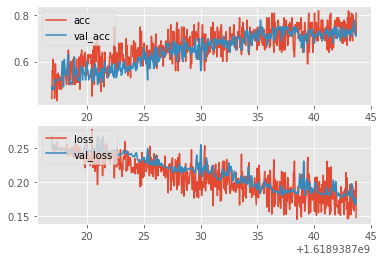

In [13]:
style.use("ggplot")

model_name = MODEL_NAME #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

Once losses start to diverge, you can find what epoch is ideal (graph by epochs)
Use pandas to graph in future
